# EAS-503 Final Project - Loan Approval Prediction

# Links to Project: 
- [MLFlow/DagsHub Experiments](https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/0?searchFilter=&orderByKey=attributes.start_time&orderByAsc=false&startTime=ALL&lifecycleFilter=Active&modelVersionFilter=All+Runs&datasetsFilter=W10%3D)
- [Docker Hub Container](https://hub.docker.com/r/frost3010/eas_503_final_project)
- [Deployed Model](http://http://165.22.43.24:8000)
- [Streamlit App](https://eas503-loanapprovalprediction.streamlit.app)

# Import Libraries

In [1]:
import sqlite3
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ydata_profiling
import os
import mlflow
from dagshub import DAGsHubLogger
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from joblib import dump
import dill

%matplotlib inline

# Create Database (3NF)

In [2]:
# Connect to SQLite database
conn = sqlite3.connect('Loan_Database.db')
cursor = conn.cursor()

# Create tables
cursor.execute('''
CREATE TABLE IF NOT EXISTS Gender (
    gender_id INTEGER PRIMARY KEY AUTOINCREMENT,
    gender TEXT UNIQUE
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Education (
    education_id INTEGER PRIMARY KEY AUTOINCREMENT,
    education TEXT UNIQUE
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS HomeOwnership (
    home_ownership_id INTEGER PRIMARY KEY AUTOINCREMENT,
    home_ownership TEXT UNIQUE
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS LoanIntent (
    intent_id INTEGER PRIMARY KEY AUTOINCREMENT,
    intent TEXT UNIQUE
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Defaults (
    defaults_id INTEGER PRIMARY KEY AUTOINCREMENT,
    defaults TEXT UNIQUE
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Person (
    person_id INTEGER PRIMARY KEY AUTOINCREMENT,
    age INTEGER,
    income REAL,
    emp_exp INTEGER,
    gender_id INTEGER,
    education_id INTEGER,
    home_ownership_id INTEGER,
    FOREIGN KEY (gender_id) REFERENCES Gender(gender_id),
    FOREIGN KEY (education_id) REFERENCES Education(education_id),
    FOREIGN KEY (home_ownership_id) REFERENCES HomeOwnership(home_ownership_id)
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Loan (
    loan_id INTEGER PRIMARY KEY AUTOINCREMENT,
    person_id INTEGER,
    amount REAL,
    interest_rate REAL,
    percent_income REAL,
    cred_hist_length REAL,
    credit_score INTEGER,
    status INTEGER,
    intent_id INTEGER,
    defaults_id INTEGER,
    FOREIGN KEY (person_id) REFERENCES Person(person_id),
    FOREIGN KEY (intent_id) REFERENCES LoanIntent(intent_id),
    FOREIGN KEY (defaults_id) REFERENCES Defaults(defaults_id)
);
''')

# Insert data into tables
with open('loan_data.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Insert into Gender table
        cursor.execute('INSERT OR IGNORE INTO Gender (gender) VALUES (?)', (row['person_gender'],))
        
        # Insert into Education table
        cursor.execute('INSERT OR IGNORE INTO Education (education) VALUES (?)', (row['person_education'],))
        
        # Insert into HomeOwnership table
        cursor.execute('INSERT OR IGNORE INTO HomeOwnership (home_ownership) VALUES (?)', (row['person_home_ownership'],))
        
        # Insert into LoanIntent table
        cursor.execute('INSERT OR IGNORE INTO LoanIntent (intent) VALUES (?)', (row['loan_intent'],))
        
        # Insert into Defaults table
        cursor.execute('INSERT OR IGNORE INTO Defaults (defaults) VALUES (?)', (row['previous_loan_defaults_on_file'],))
        
        # Insert into Person table
        cursor.execute('''
        INSERT INTO Person (age, income, emp_exp, gender_id, education_id, home_ownership_id)
        VALUES (?, ?, ?, 
                (SELECT gender_id FROM Gender WHERE gender = ?),
                (SELECT education_id FROM Education WHERE education = ?),
                (SELECT home_ownership_id FROM HomeOwnership WHERE home_ownership = ?))
        ''', (int(float(row['person_age'])), float(row['person_income']), int(row['person_emp_exp']),
              row['person_gender'], row['person_education'], row['person_home_ownership']))
        
        person_id = cursor.lastrowid
        
        # Insert into Loan table
        cursor.execute('''
        INSERT INTO Loan (person_id, amount, interest_rate, percent_income, cred_hist_length, credit_score, status, intent_id, defaults_id)
        VALUES (?, ?, ?, ?, ?, ?, ?, 
                (SELECT intent_id FROM LoanIntent WHERE intent = ?),
                (SELECT defaults_id FROM Defaults WHERE defaults = ?))
        ''', (person_id, float(row['loan_amnt']), float(row['loan_int_rate']), float(row['loan_percent_income']),
              float(row['cb_person_cred_hist_length']), int(row['credit_score']), int(row['loan_status']),
              row['loan_intent'], row['previous_loan_defaults_on_file']))

# Commit changes and close connection
conn.commit()
conn.close()

# Load Data from Database

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect('Loan_Database.db')

# SQL query with JOIN statements to fetch data from all tables
query = """
SELECT 
    l.loan_id,
    p.person_id,
    p.age,
    g.gender,
    e.education,
    p.income,
    p.emp_exp,
    h.home_ownership,
    l.amount AS loan_amount,
    li.intent AS loan_intent,
    l.interest_rate,
    l.percent_income,
    l.cred_hist_length,
    l.credit_score,
    d.defaults AS previous_defaults,
    l.status AS loan_status
FROM 
    Loan l
JOIN 
    Person p ON l.person_id = p.person_id
JOIN 
    Gender g ON p.gender_id = g.gender_id
JOIN 
    Education e ON p.education_id = e.education_id
JOIN 
    HomeOwnership h ON p.home_ownership_id = h.home_ownership_id
JOIN 
    LoanIntent li ON l.intent_id = li.intent_id
JOIN 
    Defaults d ON l.defaults_id = d.defaults_id
"""

# Execute the query and fetch the data into a Pandas DataFrame
Loan_Data = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

In [4]:
# Display the first few rows of the DataFrame
Loan_Data.head()

,loan_id,person_id,age,gender,education,income,emp_exp,home_ownership,loan_amount,loan_intent,interest_rate,percent_income,cred_hist_length,credit_score,previous_defaults,loan_status
0,1,1,22,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,2,2,21,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,3,3,25,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,4,4,23,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,5,5,24,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
Loan_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225000 entries, 0 to 224999
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loan_id            225000 non-null  int64  
 1   person_id          225000 non-null  int64  
 2   age                225000 non-null  int64  
 3   gender             225000 non-null  object 
 4   education          225000 non-null  object 
 5   income             225000 non-null  float64
 6   emp_exp            225000 non-null  int64  
 7   home_ownership     225000 non-null  object 
 8   loan_amount        225000 non-null  float64
 9   loan_intent        225000 non-null  object 
 10  interest_rate      225000 non-null  float64
 11  percent_income     225000 non-null  float64
 12  cred_hist_length   225000 non-null  float64
 13  credit_score       225000 non-null  int64  
 14  previous_defaults  225000 non-null  object 
 15  loan_status        225000 non-null  int64  
dtypes:

# Data EDA to identify variables for stratification

Loan Status Distribution:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64


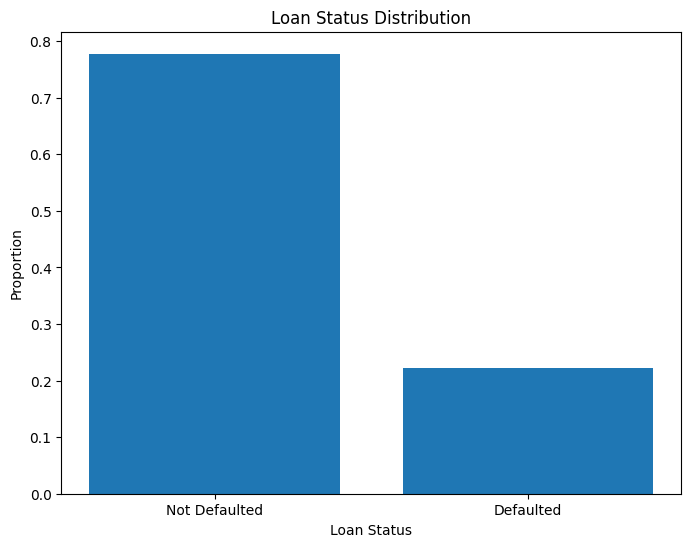

In [6]:
# Calculate the distribution of loan_status
loan_status_dist = Loan_Data['loan_status'].value_counts(normalize = True)

print("Loan Status Distribution:")
print(loan_status_dist)

# Visualize the distribution
plt.figure(figsize=(8, 6))
plt.bar(loan_status_dist.index, loan_status_dist.values)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['Not Defaulted', 'Defaulted'])
plt.show()



gender Distribution:
gender
male      0.552022
female    0.447978
Name: proportion, dtype: float64


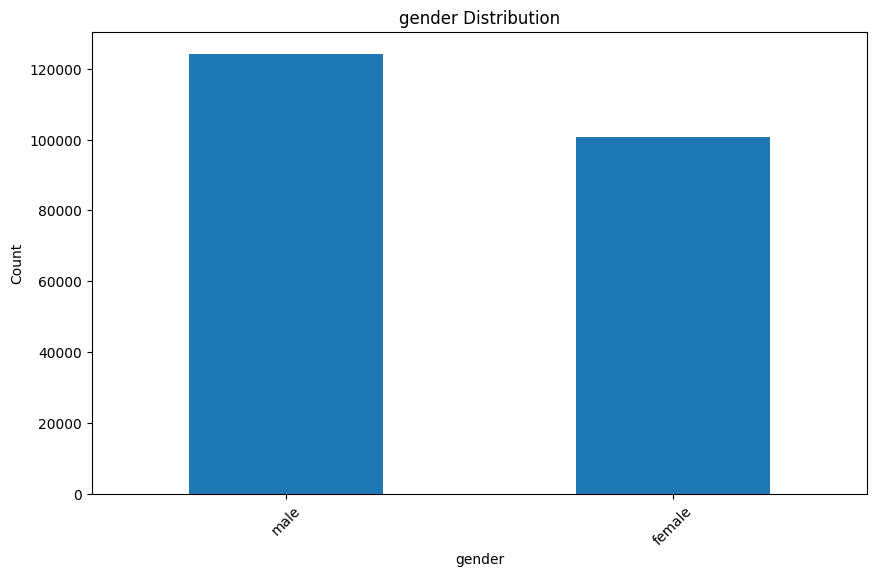


education Distribution:
education
Bachelor       0.297756
Associate      0.267289
High School    0.266044
Master         0.155111
Doctorate      0.013800
Name: proportion, dtype: float64


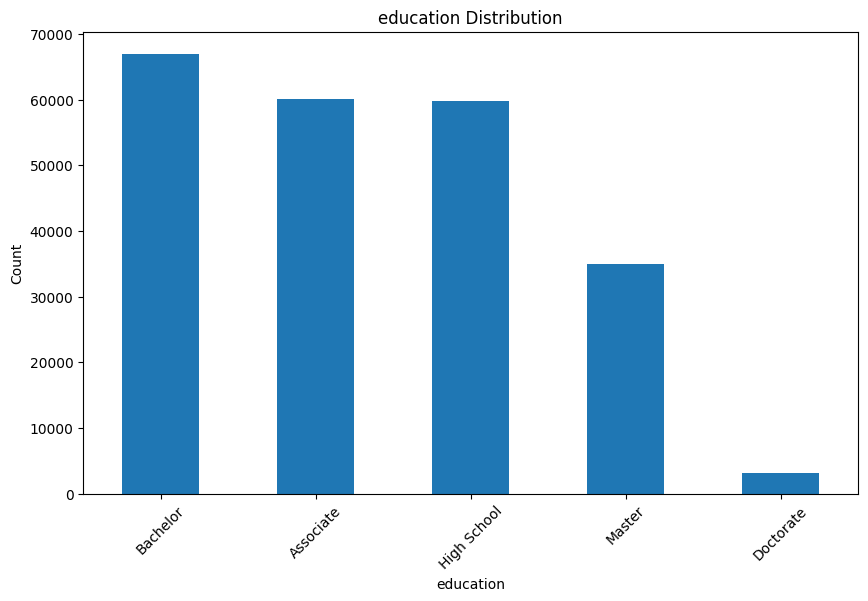


home_ownership Distribution:
home_ownership
RENT        0.520956
MORTGAGE    0.410867
OWN         0.065578
OTHER       0.002600
Name: proportion, dtype: float64


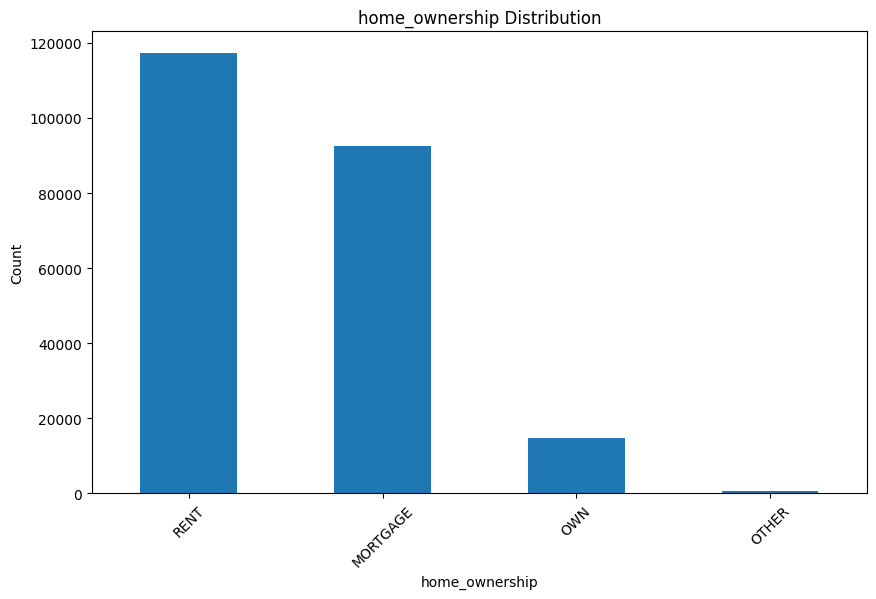


loan_intent Distribution:
loan_intent
EDUCATION            0.203400
MEDICAL              0.189956
VENTURE              0.173756
PERSONAL             0.167822
DEBTCONSOLIDATION    0.158778
HOMEIMPROVEMENT      0.106289
Name: proportion, dtype: float64


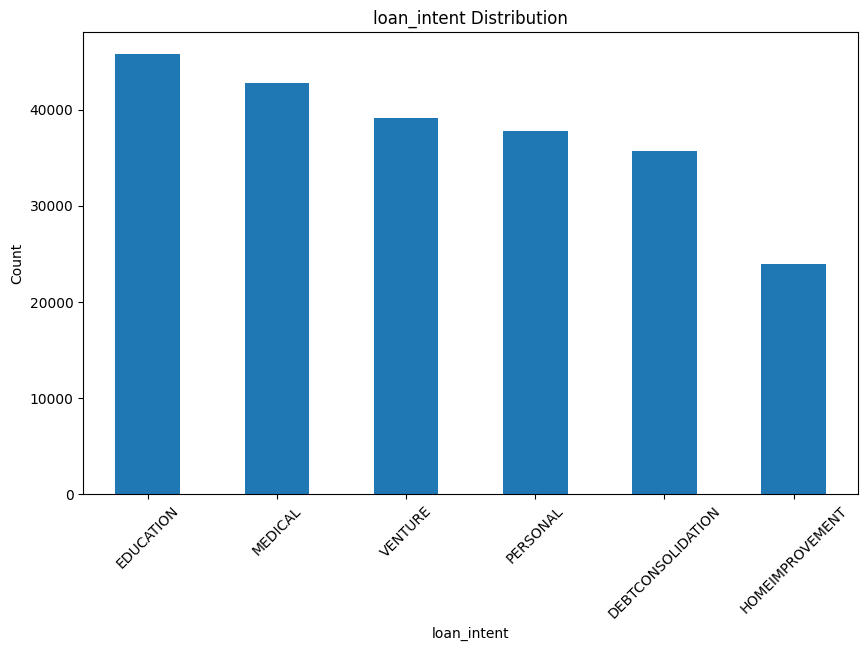


previous_defaults Distribution:
previous_defaults
Yes    0.507956
No     0.492044
Name: proportion, dtype: float64


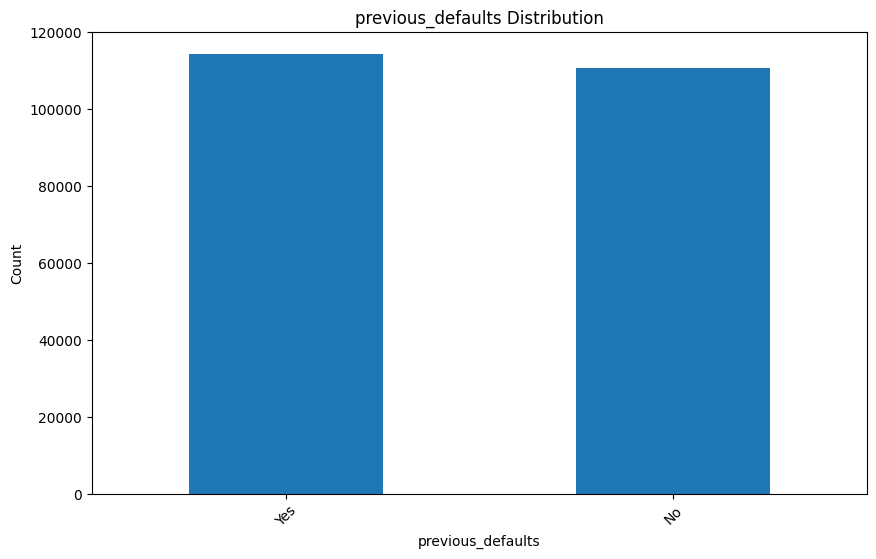

In [7]:
categorical_features = ['gender', 'education', 'home_ownership', 'loan_intent', 'previous_defaults']

for feature in categorical_features:
    print(f"\n{feature} Distribution:")
    print(Loan_Data[feature].value_counts(normalize=True))
    
    plt.figure(figsize=(10, 6))
    Loan_Data[feature].value_counts().plot(kind='bar')
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Data Stratefication

In [8]:
# Primary stratification by 'loan_status'
X = Loan_Data.drop('loan_status', axis = 1)
y = Loan_Data['loan_status']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, stratify = y, random_state = 42)

# Verify stratification
print("Train set distribution:")
print(y_train.value_counts(normalize = True))
print("\nTest set distribution:")
print(y_test.value_counts(normalize = True))

Train set distribution:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64

Test set distribution:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64


# Data visualization using YData-Profiler

In [9]:
# Generate a profile report
profile = ydata_profiling.ProfileReport(Loan_Data, title = 'Loan Data Profile Report')

# Save the report to an HTML file
profile.to_file('Loan_Data_Profile_Report.html')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
model_result_exp_1 = {}
model_result_exp_2 = {}
model_result_exp_3 = {}
model_result_exp_4 = {}
model_result_exp_5 = {}

# Experiment 1

In [22]:
# Configure MLFlow to log to DagsHub
mlflow.set_tracking_uri('https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow')
os.environ['MLFLOW_TRACKING_USERNAME'] = 'yash.mathur3010'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'e24cbf25e00e26e603a33b779c08c116c2ad4baa'
mlflow.set_experiment('Loan_Approval_Prediction_Exp_1')

<Experiment: artifact_location='mlflow-artifacts:/a2dcae8427d24f1ca0d9df72568c0aca', creation_time=1734725554895, experiment_id='0', last_update_time=1734725554895, lifecycle_stage='active', name='Loan_Approval_Prediction_Exp_1', tags={}>

In [23]:
# Preprocessing pipeline for numeric and categorical features
numeric_features = ['age', 'income', 'emp_exp', 'loan_amount', 'interest_rate', 'percent_income', 'cred_hist_length', 'credit_score']
categorical_features = ['gender', 'education', 'home_ownership', 'loan_intent', 'previous_defaults']

# Define transformations
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler()),
                                        ('log_transform', FunctionTransformer(lambda x: np.log1p(np.maximum(x, 0))))])
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# Combine preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(transformers = [('num', numeric_transformer, numeric_features),
                                                 ('cat', categorical_transformer, categorical_features)])

# Define the full pipeline with Logistic Regression as the model
pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                             ('scaler', MinMaxScaler()),
                             ('classifier', LogisticRegression(max_iter = 1000))])

In [24]:
# Cross-validation setup (3-fold or 10-fold)
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Perform cross-validation and log results to MLFlow/DagsHub
with mlflow.start_run():

    # Cross-validation scores (F1-score)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv = cv, scoring = 'f1')
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    # Fit the pipeline on the entire training set and evaluate on the test set
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Evaluate performance on test data
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    model_result_exp_1['Logistic Regression'] = {
            'model': pipeline,
            'accuracy': accuracy,
            'f1_score': f1,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp,
            'cv_f1_mean': np.mean(cv_scores),
            'cv_f1_std': np.std(cv_scores)
        }

    # Log metrics to MLFlow/DagsHub
    mlflow.log_metric('mean_cv_f1_score', mean_cv_score)
    mlflow.log_metric('std_cv_f1_score', std_cv_score)
    mlflow.log_metric('test_f1_score', f1)
    mlflow.log_metric('true_positive', tp)
    mlflow.log_metric('true_negative', tn)
    mlflow.log_metric('false_positive', fp)
    mlflow.log_metric('false_negative', fn)

    mlflow.log_metrics({'mean_cv_f1_score': mean_cv_score,
                        'std_cv_f1_score': std_cv_score,
                        'test_f1_score': f1,
                        'true_positive': tp,
                        'true_negative': tn,
                        'false_positive': fp,
                        'false_negative': fn})

    mlflow.end_run()

🏃 View run skillful-hare-731 at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/0/runs/07499fe1851443fd91d3bf9d62790797
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/0


In [25]:
# Define hyperparameter grid for Logistic Regression
param_grid = {'classifier__C' : [0.01, 0.1, 1.0],
              'classifier__penalty' : ['l2']}

# Use GridSearchCV to find the best parameters within the pipeline
grid_search = GridSearchCV(pipeline, param_grid = param_grid, cv = cv, scoring = 'f1')
grid_search.fit(X_train, y_train)

# Log best parameters and best score to MLFlow/DagsHub
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

mlflow.log_params(best_params)
mlflow.log_metric('best_cv_f1_score', best_f1_score)

print(f'Best Parameters: {best_params}')
print(f'Best CV F1-Score: {best_f1_score}')
mlflow.end_run()

Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Best CV F1-Score: 0.7593502224894697
🏃 View run honorable-yak-107 at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/0/runs/8ff6a8961aa543d3bec1a390bc4be30a
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/0


# Experiment 2

In [26]:
# Configure MLFlow to log to DagsHub
mlflow.set_tracking_uri('https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow')
os.environ['MLFLOW_TRACKING_USERNAME'] = 'yash.mathur3010'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'e24cbf25e00e26e603a33b779c08c116c2ad4baa'
mlflow.set_experiment('Loan_Approval_Prediction_Exp_2')

<Experiment: artifact_location='mlflow-artifacts:/639e3403b42942ebb60d54274e21acfb', creation_time=1734725621738, experiment_id='1', last_update_time=1734725621738, lifecycle_stage='active', name='Loan_Approval_Prediction_Exp_2', tags={}>

In [27]:
# Create pipelines
models = {
    'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', LogisticRegression(max_iter = 1000))]),
    'Ridge Classifier': Pipeline(steps=[('preprocessor', preprocessor),
                                        ('classifier', RidgeClassifier())]),
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', RandomForestClassifier())]),
    'XGBoost': Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier())])}

In [28]:
for name, model in models.items():
    with mlflow.start_run(run_name = name):
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'f1')
        
        model_result_exp_2[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_score': f1,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp,
            'cv_f1_mean': np.mean(cv_scores),
            'cv_f1_std': np.std(cv_scores)
        }
        
        # Log parameters
        mlflow.log_params(model.get_params())
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("true_negatives", tn)
        mlflow.log_metric("false_positives", fp)
        mlflow.log_metric("false_negatives", fn)
        mlflow.log_metric("true_positives", tp)
        mlflow.log_metric("cv_f1_mean", np.mean(cv_scores))
        mlflow.log_metric("cv_f1_std", np.std(cv_scores))
        
        # Log the model
        mlflow.sklearn.log_model(model, name)
        
        print(f"Finished training {name}")
        mlflow.end_run()
        

2024/12/21 18:17:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Finished training Logistic Regression
🏃 View run Logistic Regression at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/1/runs/4c934e5faca148eb81e10c02c11e9d41
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/1


2024/12/21 18:17:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Finished training Ridge Classifier
🏃 View run Ridge Classifier at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/1/runs/545fd7999a27457bb7a53e26736502ad
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/1


2024/12/21 18:18:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Finished training Random Forest
🏃 View run Random Forest at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/1/runs/b601a9872d5140ff9f3c22def66c4953
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/1


2024/12/21 18:19:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Finished training XGBoost
🏃 View run XGBoost at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/1/runs/1c732f1a96d24a2d9209bef5c51b8552
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/1


# Experiment 3

In [29]:
# Configure MLFlow to log to DagsHub
mlflow.set_tracking_uri('https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow')
os.environ['MLFLOW_TRACKING_USERNAME'] = 'yash.mathur3010'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'e24cbf25e00e26e603a33b779c08c116c2ad4baa'
mlflow.set_experiment('Loan_Approval_Prediction_Exp_3')

<Experiment: artifact_location='mlflow-artifacts:/4528d998a43240fba821e256c99c9951', creation_time=1734725802361, experiment_id='2', last_update_time=1734725802361, lifecycle_stage='active', name='Loan_Approval_Prediction_Exp_3', tags={}>

In [30]:
# Feature Engineering
# 1. Income to Loan Amount Ratio
X_train['income_to_loan_ratio'] = X_train['income'] / X_train['loan_amount']
X_test['income_to_loan_ratio'] = X_test['income'] / X_test['loan_amount']

# 2. Employment Experience to Age Ratio
X_train['emp_exp_to_age_ratio'] = X_train['emp_exp'] / X_train['age']
X_test['emp_exp_to_age_ratio'] = X_test['emp_exp'] / X_test['age']

# 3. Credit Score to Income Ratio
X_train['credit_score_to_income_ratio'] = X_train['credit_score'] / X_train['income']
X_test['credit_score_to_income_ratio'] = X_test['credit_score'] / X_test['income']

# 4. Loan Intent Encoding (Convert loan intent into numerical values)
loan_intent_mapping = {'PERSONAL': 1,
                       'EDUCATION': 2,
                       'MEDICAL': 3,
                       'VENTURE': 4,
                       'HOMEIMPROVEMENT': 5,
                       'DEBTCONSOLIDATION': 6}

X_train['loan_intent_encoded'] = X_train['loan_intent'].map(loan_intent_mapping)
X_test['loan_intent_encoded'] = X_test['loan_intent'].map(loan_intent_mapping)

In [31]:
# Preprocessing pipeline for numeric and categorical features
numeric_features = ['age', 'income', 'emp_exp', 'loan_amount', 'interest_rate', 'percent_income', 'cred_hist_length', 'credit_score', 'income_to_loan_ratio', 'emp_exp_to_age_ratio',
                    'credit_score_to_income_ratio']
categorical_features = ['gender', 'education', 'home_ownership', 'loan_intent_encoded', 'previous_defaults']

# Define transformations
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler()),
                                        ('log_transform', FunctionTransformer(lambda x: np.log1p(np.maximum(x, 0))))])
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# Combine preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(transformers = [('num', numeric_transformer, numeric_features),
                                                 ('cat', categorical_transformer, categorical_features)])

In [32]:
# Create pipelines for each classifier
models = {'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                                 ('classifier', LogisticRegression(max_iter=1000))]),
          'Ridge Classifier': Pipeline(steps=[('preprocessor', preprocessor),
                                              ('classifier', RidgeClassifier())]),
          'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', RandomForestClassifier())]),
          'XGBoost': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])}

In [33]:
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on test data
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        model_result_exp_3[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_score': f1,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp,
            'cv_f1_mean': np.mean(cv_scores),
            'cv_f1_std': np.std(cv_scores)
        }

        # Log parameters and metrics to MLFlow
        mlflow.log_params(model.get_params())
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("true_negatives", tn)
        mlflow.log_metric("false_positives", fp)
        mlflow.log_metric("false_negatives", fn)
        mlflow.log_metric("true_positives", tp)

        print(f"Finished training {name} with accuracy: {accuracy:.4f} and F1 score: {f1:.4f}")
        mlflow.end_run()


Finished training Logistic Regression with accuracy: 0.9034 and F1 score: 0.7774
🏃 View run Logistic Regression at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/2/runs/2facc805f8bf4f73a38aafe4f4a7e649
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/2
Finished training Ridge Classifier with accuracy: 0.8989 and F1 score: 0.7572
🏃 View run Ridge Classifier at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/2/runs/a3daa135a8fe4b8f810ad7b50e277802
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/2
Finished training Random Forest with accuracy: 0.9991 and F1 score: 0.9979
🏃 View run Random Forest at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/2/runs/51a49211dd874df391c8b061e7b01d15
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/

/opt/miniconda3/envs/EAS_503/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:20:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished training XGBoost with accuracy: 0.9548 and F1 score: 0.8927
🏃 View run XGBoost at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/2/runs/9eadb706c5624e0d92613b374811e2da
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/2


# Experiment 4

In [34]:
# Configure MLFlow to log to DagsHub
mlflow.set_tracking_uri('https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow')
os.environ['MLFLOW_TRACKING_USERNAME'] = 'yash.mathur3010'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'e24cbf25e00e26e603a33b779c08c116c2ad4baa'
mlflow.set_experiment('Loan_Approval_Prediction_Exp_4')

<Experiment: artifact_location='mlflow-artifacts:/623b5c4d81454c059f8e616687221e61', creation_time=1734725851905, experiment_id='3', last_update_time=1734725851905, lifecycle_stage='active', name='Loan_Approval_Prediction_Exp_4', tags={}>

In [35]:
X_train = X_train.drop('loan_intent_encoded', axis=1)
X_test = X_test.drop('loan_intent_encoded', axis=1)

In [36]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Correlation Threshold
correlation_matrix = X_train_encoded.corr()
correlation_threshold = 0.4
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_encoded, y_train)
importances = rf.feature_importances_
feature_importance_threshold = 0.2
important_features = [feature for feature, importance in zip(X_train_encoded.columns, importances) if importance > feature_importance_threshold]

# Variance Threshold
selector = VarianceThreshold(threshold=0.2)
selector.fit(X_train_encoded)
variance_features = X_train_encoded.columns[selector.get_support(indices=True)]

# Combine selected features
selected_features = list(set(correlated_features) | set(important_features) | set(variance_features))

🏃 View run Feature Selection at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/3/runs/7dd13386fa494ce9a31c0431dba1bc8f
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/3
Selected Features: ['person_id', 'loan_id', 'gender_male', 'income_to_loan_ratio', 'previous_defaults_Yes', 'age', 'emp_exp_to_age_ratio', 'emp_exp', 'credit_score', 'loan_amount', 'percent_income', 'home_ownership_RENT', 'interest_rate', 'education_Bachelor', 'cred_hist_length', 'credit_score_to_income_ratio', 'income']
Number of Selected Features: 17


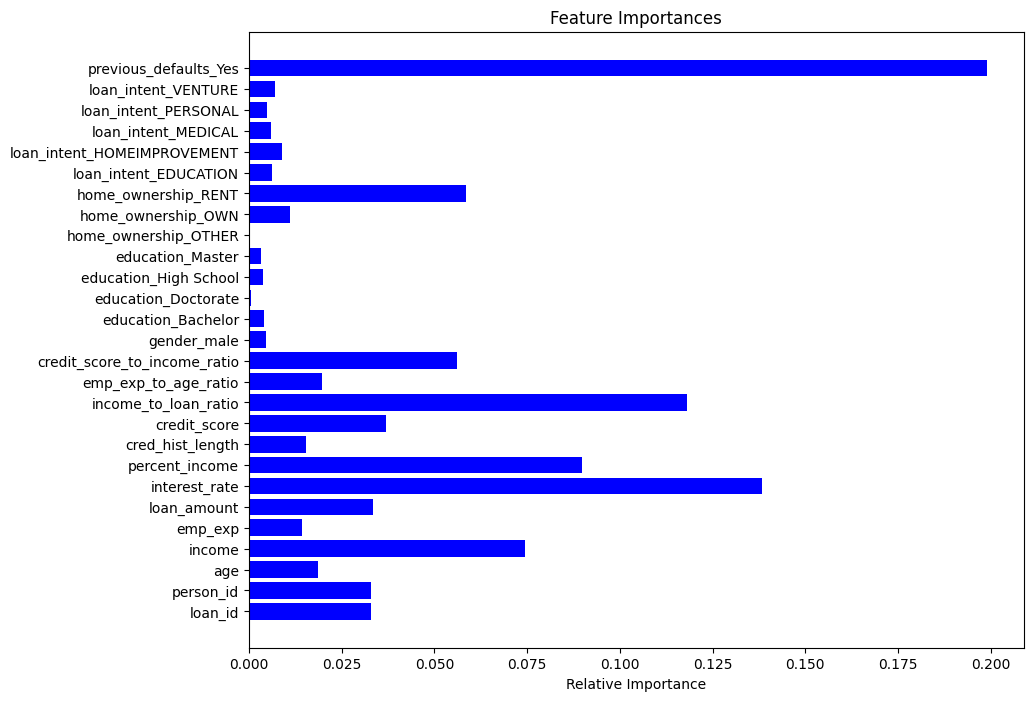

In [37]:
with mlflow.start_run(run_name="Feature Selection"):
    # Log selected features and their count
    mlflow.log_param("selected_features", selected_features)
    mlflow.log_metric("num_selected_features", len(selected_features))
    
    # Log feature importance plot
    plt.figure(figsize=(10, 8))
    plt.title('Feature Importances')
    plt.barh(X_train_encoded.columns, importances, color='b', align='center')
    plt.xlabel('Relative Importance')
    plt.savefig("feature_importances.png")
    mlflow.log_artifact("feature_importances.png")
    mlflow.end_run()

print(f"Selected Features: {selected_features}")
print(f"Number of Selected Features: {len(selected_features)}")

In [38]:
# Configure MLFlow to log to DagsHub
mlflow.set_tracking_uri('https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow')
os.environ['MLFLOW_TRACKING_USERNAME'] = 'yash.mathur3010'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'e24cbf25e00e26e603a33b779c08c116c2ad4baa'
mlflow.set_experiment('Loan_Approval_Prediction_Exp_4')

<Experiment: artifact_location='mlflow-artifacts:/623b5c4d81454c059f8e616687221e61', creation_time=1734725851905, experiment_id='3', last_update_time=1734725851905, lifecycle_stage='active', name='Loan_Approval_Prediction_Exp_4', tags={}>

In [39]:
# Preprocessing pipeline for numeric and categorical features
numeric_features = ['income', 'emp_exp', 'cred_hist_length', 'percent_income','interest_rate', 'age', 'income_to_loan_ratio', 'emp_exp_to_age_ratio', 'credit_score_to_income_ratio', 'credit_score']

categorical_features = ['previous_defaults_Yes', 'gender_male', 'education_Bachelor', 'home_ownership_RENT']

# Define transformations
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler()),
                                        ('log_transform', FunctionTransformer(lambda x: np.log1p(np.maximum(x, 0))))])
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# Combine preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(transformers = [('num', numeric_transformer, numeric_features),
                                                 ('cat', categorical_transformer, categorical_features)])

In [40]:
# Create pipelines for each classifier
models = {'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                                 ('classifier', LogisticRegression(max_iter=1000))]),
          'Ridge Classifier': Pipeline(steps=[('preprocessor', preprocessor),
                                              ('classifier', RidgeClassifier())]),
          'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', RandomForestClassifier())]),
          'XGBoost': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])}

In [41]:
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Train the model
        model.fit(X_train_encoded, y_train)
        
        # Make predictions on test data
        y_pred = model.predict(X_test_encoded)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        model_result_exp_4[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_score': f1,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp,
            'cv_f1_mean': np.mean(cv_scores),
            'cv_f1_std': np.std(cv_scores)
        }

        # Log parameters and metrics to MLFlow
        mlflow.log_params(model.get_params())
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("true_negatives", tn)
        mlflow.log_metric("false_positives", fp)
        mlflow.log_metric("false_negatives", fn)
        mlflow.log_metric("true_positives", tp)

        print(f"Finished training {name} with accuracy: {accuracy:.4f} and F1 score: {f1:.4f}")
        mlflow.end_run()

Finished training Logistic Regression with accuracy: 0.8983 and F1 score: 0.7662
🏃 View run Logistic Regression at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/3/runs/814765a5e18f435d8ba79d1be999a7f0
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/3
Finished training Ridge Classifier with accuracy: 0.8954 and F1 score: 0.7487
🏃 View run Ridge Classifier at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/3/runs/429d915b9c0b4baa87ba1e6645c7b6c3
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/3
Finished training Random Forest with accuracy: 0.9979 and F1 score: 0.9952
🏃 View run Random Forest at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/3/runs/f6bf76863eda44cfbe64ca7eca15746e
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/

/opt/miniconda3/envs/EAS_503/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:21:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished training XGBoost with accuracy: 0.9411 and F1 score: 0.8585
🏃 View run XGBoost at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/3/runs/b9536ecf235042bbaca1f7cc89fd03cf
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/3


# Experiment 5

In [42]:
# Configure MLFlow to log to DagsHub
mlflow.set_tracking_uri('https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow')
os.environ['MLFLOW_TRACKING_USERNAME'] = 'yash.mathur3010'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'e24cbf25e00e26e603a33b779c08c116c2ad4baa'
mlflow.set_experiment('Loan_Approval_Prediction_Exp_5')

<Experiment: artifact_location='mlflow-artifacts:/e51cc6f2a25e4bc8b6c236df66184f03', creation_time=1734725933923, experiment_id='4', last_update_time=1734725933923, lifecycle_stage='active', name='Loan_Approval_Prediction_Exp_5', tags={}>

In [43]:
# Preprocessing pipeline for numeric and categorical features
numeric_features = ['age', 'income', 'emp_exp', 'loan_amount', 'interest_rate', 'percent_income', 'cred_hist_length', 'credit_score']
categorical_features = ['gender', 'education', 'home_ownership', 'loan_intent', 'previous_defaults']

# Define transformations
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler()),
                                        ('log_transform', FunctionTransformer(lambda x: np.log1p(np.maximum(x, 0))))])
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# Combine preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(transformers = [('num', numeric_transformer, numeric_features),
                                                 ('cat', categorical_transformer, categorical_features)])


In [44]:
# Preprocess the training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply PCA with the number of components to retain 95% variance
num_components = 16  # Based on scree plot
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_preprocessed)
X_test_pca = pca.transform(X_test_preprocessed)

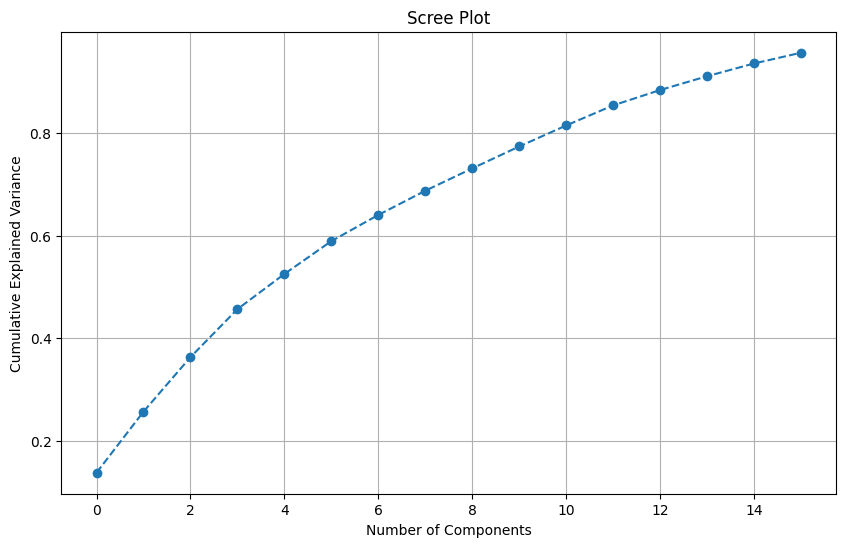

Number of Components for 95% Variance: 16


In [45]:
# Calculate explained variance
explained_variance = pca.explained_variance_ratio_

# Create a scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine the number of components to retain (95% variance)
num_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1
print(f"Number of Components for 95% Variance: {num_components}")

In [46]:
pca_transformer = PCA(n_components=num_components)
models = {'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                                 ('pca', pca_transformer),
                                                 ('classifier', LogisticRegression(max_iter=1000))]),
          'Ridge Classifier': Pipeline(steps=[('preprocessor', preprocessor),
                                              ('pca', pca_transformer),
                                              ('classifier', RidgeClassifier())]),
          'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                                           ('pca', pca_transformer),
                                           ('classifier', RandomForestClassifier())]),
          'XGBoost': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('pca', pca_transformer),
                                     ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])}

In [47]:
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on test data
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        model_result_exp_5[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_score': f1,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp,
            'cv_f1_mean': np.mean(cv_scores),
            'cv_f1_std': np.std(cv_scores)
        }

        # Log parameters and metrics to MLFlow
        mlflow.log_params(model.get_params())
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("true_negatives", tn)
        mlflow.log_metric("false_positives", fp)
        mlflow.log_metric("false_negatives", fn)
        mlflow.log_metric("true_positives", tp)

        print(f"Finished training {name} with accuracy: {accuracy:.4f} and F1 score: {f1:.4f}")
        mlflow.end_run()

Finished training Logistic Regression with accuracy: 0.8970 and F1 score: 0.7615
🏃 View run Logistic Regression at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/4/runs/9bc5a061d14c4c73ba492b6e8e94b649
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/4
Finished training Ridge Classifier with accuracy: 0.8882 and F1 score: 0.7300
🏃 View run Ridge Classifier at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/4/runs/8860454fe0d245f892c329b2d6fc39ad
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/4
Finished training Random Forest with accuracy: 0.9948 and F1 score: 0.9883
🏃 View run Random Forest at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/4/runs/12905ae392e14cd58634c97986fd8e0d
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/

/opt/miniconda3/envs/EAS_503/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:22:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished training XGBoost with accuracy: 0.9432 and F1 score: 0.8653
🏃 View run XGBoost at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/4/runs/88a4645a23af4d5e9c72572ceda442d4
🧪 View experiment at: https://dagshub.com/yash.mathur3010/Loan_Approval_Prediction.mlflow/#/experiments/4


# F1-Score Plot

In [48]:
model_result_dict_list = [model_result_exp_1, model_result_exp_2, model_result_exp_3, model_result_exp_4, model_result_exp_5]
model_results_comnbined_dict = {}

i = 1
for each_dict in model_result_dict_list:
    for outer_key, inner_dict in each_dict.items():
        for inner_key, value in inner_dict.items():
            key = outer_key + ' Exp ' + str(i)
            if (inner_key == 'f1_score'):
                model_results_comnbined_dict[key] = value
    i = int(i) + 1

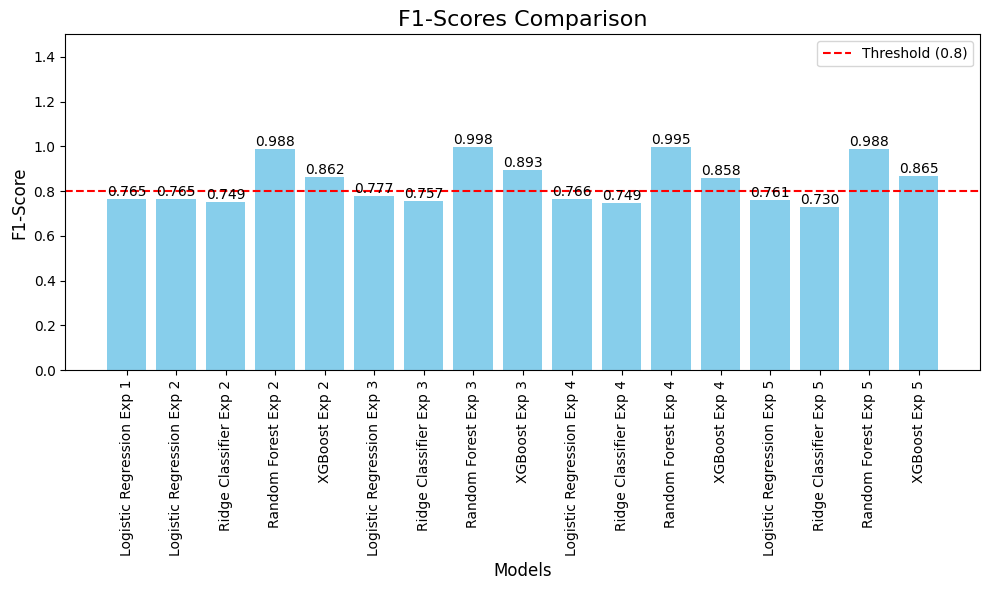

In [49]:
# Assuming your dictionary is named 'f1_scores'
model_results_comnbined_dict

# Create lists for x-axis labels and y-axis values
models = list(model_results_comnbined_dict.keys())
scores = list(model_results_comnbined_dict.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, scores, color='skyblue')

# Customize the plot
plt.title('F1-Scores Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.ylim(0, 1.5)
plt.xticks(rotation = 90)

# Add value labels on top of each bar
for i, score in enumerate(scores):
    plt.text(i, score, f'{score:.3f}', ha='center', va='bottom')

# Add a horizontal line at y=0.8 for reference
plt.axhline(y=0.8, color='red', linestyle='--', label='Threshold (0.8)')

plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Best model fit and save

In [50]:
# Feature Engineering
# 1. Income to Loan Amount Ratio
best_X_train = X_train
best_X_test = X_test

best_X_train['income_to_loan_ratio'] = best_X_train['income'] / best_X_train['loan_amount']
best_X_test['income_to_loan_ratio'] = best_X_test['income'] / best_X_test['loan_amount']

# 2. Employment Experience to Age Ratio
best_X_train['emp_exp_to_age_ratio'] = best_X_train['emp_exp'] / best_X_train['age']
best_X_test['emp_exp_to_age_ratio'] = best_X_test['emp_exp'] / best_X_test['age']

# 3. Credit Score to Income Ratio
best_X_train['credit_score_to_income_ratio'] = best_X_train['credit_score'] / best_X_train['income']
best_X_test['credit_score_to_income_ratio'] = best_X_test['credit_score'] / best_X_test['income']

# 4. Loan Intent Encoding (Convert loan intent into numerical values)
loan_intent_mapping = {'PERSONAL': 1,
                       'EDUCATION': 2,
                       'MEDICAL': 3,
                       'VENTURE': 4,
                       'HOMEIMPROVEMENT': 5,
                       'DEBTCONSOLIDATION': 6}

best_X_train['loan_intent_encoded'] = best_X_train['loan_intent'].map(loan_intent_mapping)
best_X_test['loan_intent_encoded'] = best_X_test['loan_intent'].map(loan_intent_mapping)

In [51]:
# Preprocessing pipeline for numeric and categorical features
numeric_features = ['age', 'income', 'emp_exp', 'loan_amount', 'interest_rate', 'percent_income', 'cred_hist_length', 'credit_score', 'income_to_loan_ratio', 'emp_exp_to_age_ratio',
                    'credit_score_to_income_ratio']
categorical_features = ['gender', 'education', 'home_ownership', 'loan_intent_encoded', 'previous_defaults']

# # Define transformations
# def log_transform(x):
#     return np.log1p(np.maximum(x, 0))

# numeric_transformer = Pipeline(steps = [('scaler', StandardScaler()),
#                                         ('log_transform', FunctionTransformer(lambda x: np.log1p(np.maximum(x, 0))))])

numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# Combine preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(transformers = [('num', numeric_transformer, numeric_features),
                                                 ('cat', categorical_transformer, categorical_features)])

In [52]:
best_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier())])

In [53]:
best_model.fit(best_X_train, y_train)
y_pred = best_model.predict(best_X_test)
        
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"Best Model Random Forest with feature enginerring having accuracy: {accuracy:.4f} and F1 score: {f1:.4f}")

dump(best_model, 'Best_Loan_Approval_Model.joblib')

print('Model Saved')

Best Model Random Forest with feature enginerring having accuracy: 0.9996 and F1 score: 0.9990
Model Saved
